# Satellite Data Analysis for Riga, Latvia

This notebook demonstrates satellite data analysis for Riga, Latvia using Sentinel Hub APIs in the Copernicus Data Space Ecosystem. The analysis includes:

- Creating true color images using Sentinel-2 data
- Generating NDVI maps for vegetation analysis
- Time series analysis of NDVI for agricultural fields around Riga

Based on the Living Planet Symposium 2025 workshop methodology.

## Import Required Libraries

Import the necessary libraries for satellite data processing, visualization, and analysis.

In [ ]:
# Utilities
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import geopandas as gpd
import contextily as cx
import getpass
import numpy as np
from shapely.geometry import box

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    parse_time,
)

from utils import plot_image

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

In [99]:
# If you have already configured a profile, uncomment and specify your profile name
config = SHConfig("cdse")

## Define Area of Interest (Riga, Latvia)

Define the geographic boundaries for Riga, Latvia. The bounding box coordinates are in WGS84 format: [longitude_min, latitude_min, longitude_max, latitude_max].

Riga is located at approximately 56.95°N, 24.1°E. We'll define a bounding box that covers the city and surrounding areas.

Image shape at 10 m resolution: (2222, 2136) pixels


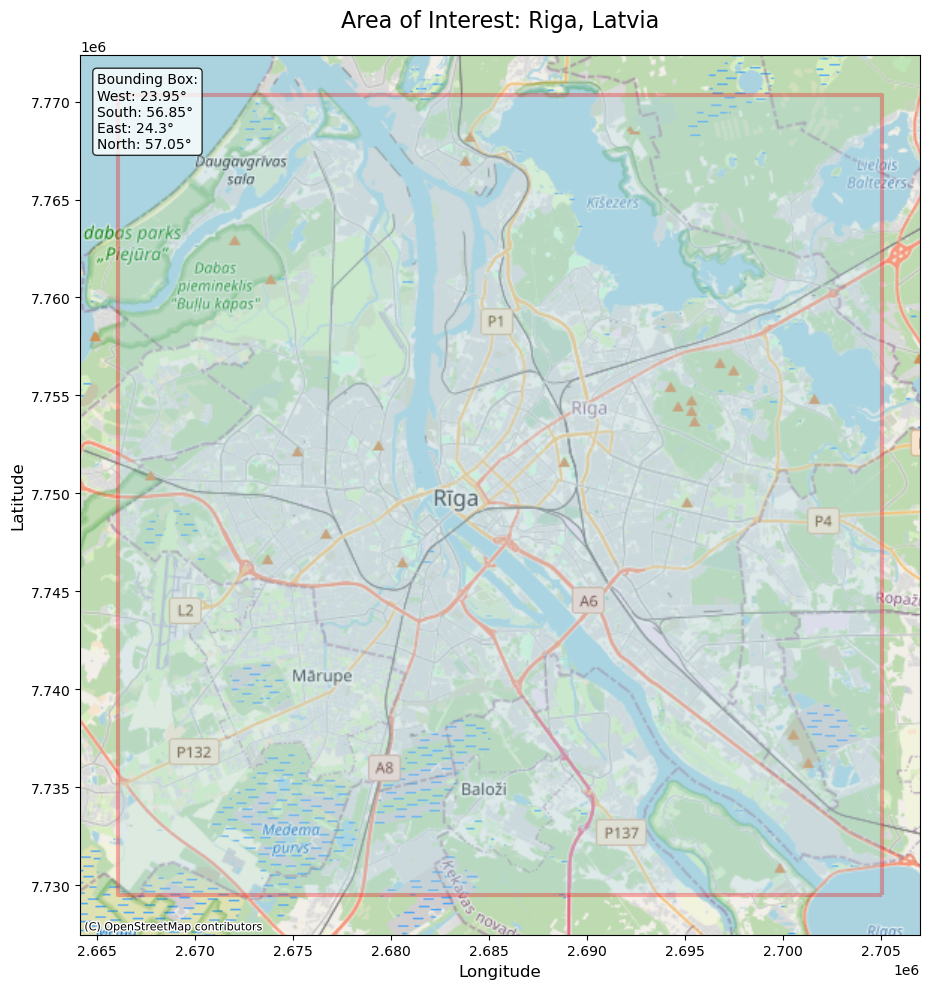

In [39]:
# Bounding box for Riga, Latvia - adjusted to stay within 2500x2500 pixel limit
# [west, south, east, north] in WGS84 coordinates
# Focused on Riga city center and immediate surroundings
riga_coords_wgs84 = [23.95, 56.85, 24.3, 57.05]

# Set resolution in meters
resolution = 10

# Create BBox object and calculate image dimensions
riga_bbox = BBox(bbox=riga_coords_wgs84, crs=CRS.WGS84)
riga_size = bbox_to_dimensions(riga_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {riga_size} pixels")

# Visualize the Area of Interest
# Create a GeoDataFrame for the bounding box
bbox_geom = box(riga_coords_wgs84[0], riga_coords_wgs84[1], 
                riga_coords_wgs84[2], riga_coords_wgs84[3])
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_geom], crs='EPSG:4326')

# Reproject to Web Mercator for basemap
bbox_gdf_wm = bbox_gdf.to_crs(epsg=3857)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 10))
bbox_gdf_wm.plot(ax=ax, alpha=0.3, edgecolor="red", facecolor="lightblue", linewidth=3)

# Add basemap
cx.add_basemap(ax, crs=bbox_gdf_wm.crs, source=cx.providers.OpenStreetMap.Mapnik)

# Formatting
ax.set_title("Area of Interest: Riga, Latvia", fontsize=16, pad=20)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add coordinate labels
ax.text(0.02, 0.98, f"Bounding Box:\nWest: {riga_coords_wgs84[0]}°\nSouth: {riga_coords_wgs84[1]}°\nEast: {riga_coords_wgs84[2]}°\nNorth: {riga_coords_wgs84[3]}°", 
        transform=ax.transAxes, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout()
plt.show()

## Processing API

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastCC` which will return pixels from the least cloudy acquisition in the specified time period.

### Create True Color Image

Generate a true color composite image using Sentinel-2 L2A data. We'll use the red (B04), green (B03), and blue (B02) bands to create a natural color representation of Riga.

The evalscript defines how satellite data should be processed and what values should be returned.

In [53]:
# Evalscript for true color composite (RGB)
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# Create the request for true color image
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2025-06-01", "2025-06-30"),  # Summer imagery for better visibility
            #other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},  # Least cloudy image
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=riga_bbox,
    size=riga_size,
    config=config,
)

In [54]:
# Download and process the true color image
print("Downloading true color image for Riga, Latvia...")
true_color_imgs = request_true_color.get_data()

print(f"Returned data type: {type(true_color_imgs)}, length: {len(true_color_imgs)}")
print(f"Image shape: {true_color_imgs[0].shape}, dtype: {true_color_imgs[0].dtype}")

Returned data type: <class 'list'>, length: 1
Image shape: (2136, 2222, 3), dtype: uint8
Returned data type: <class 'list'>, length: 1
Image shape: (2136, 2222, 3), dtype: uint8


True Color Image of Riga, Latvia


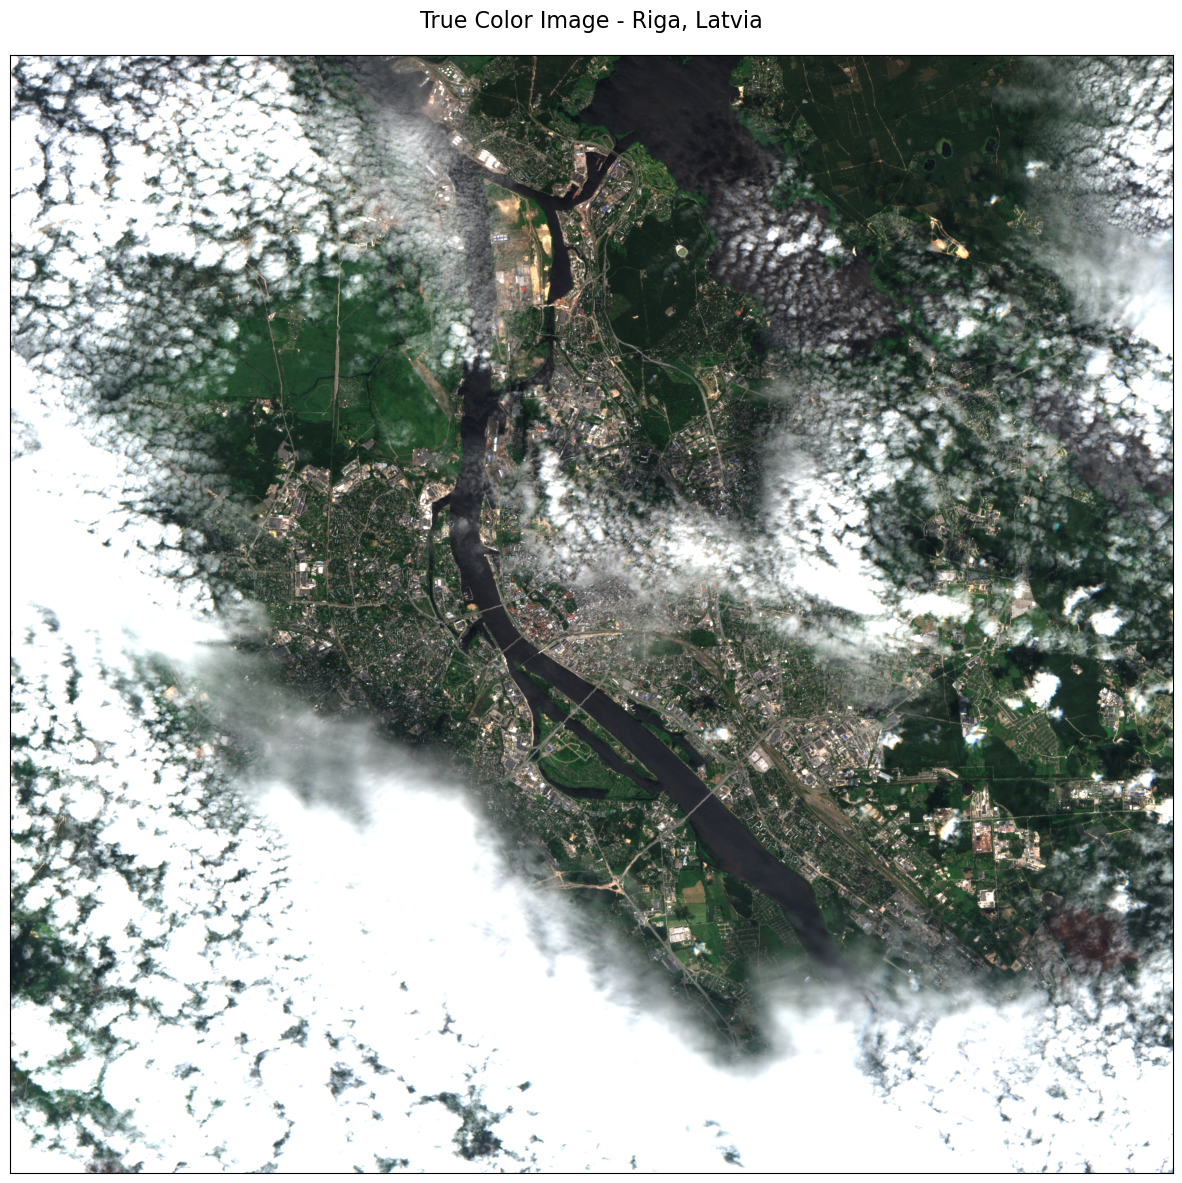

In [55]:
# Display the true color image
image = true_color_imgs[0]
print("True Color Image of Riga, Latvia")

# Plot with enhanced brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))
plt.title("True Color Image - Riga, Latvia", fontsize=16, pad=20)
plt.show()

### Calculate NDVI Map

NDVI is a very commonly used spectral vegetation index for vegetation monitoring, for example, monitoring crop growth and yields. As you will notice in the codeblock below, the evalscript has changed substantially:
- we are only using Band 4 and Band 8 as an input into our script.
- In the `evaluatePixel()` function, we calculate NDVI and visualise this using the `imgVals` array.

In [ ]:
# Evalscript for NDVI calculation with color visualization
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    // Color coding for different NDVI ranges
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

# Create the request for NDVI map
request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2025-06-01", "2025-06-30"),  # Summer imagery for better visibility
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=riga_bbox,
    size=riga_size,
    config=config,
)

In [30]:
# Download and process the NDVI image
print("Downloading NDVI map for Riga, Latvia...")
ndvi_img = request_ndvi_img.get_data()

print(f"NDVI data type: {type(ndvi_img)}, length: {len(ndvi_img)}")
print(f"NDVI image shape: {ndvi_img[0].shape}, dtype: {ndvi_img[0].dtype}")

NDVI data type: <class 'list'>, length: 1
NDVI image shape: (2136, 2222, 4), dtype: uint8


NDVI Map of Riga, Latvia


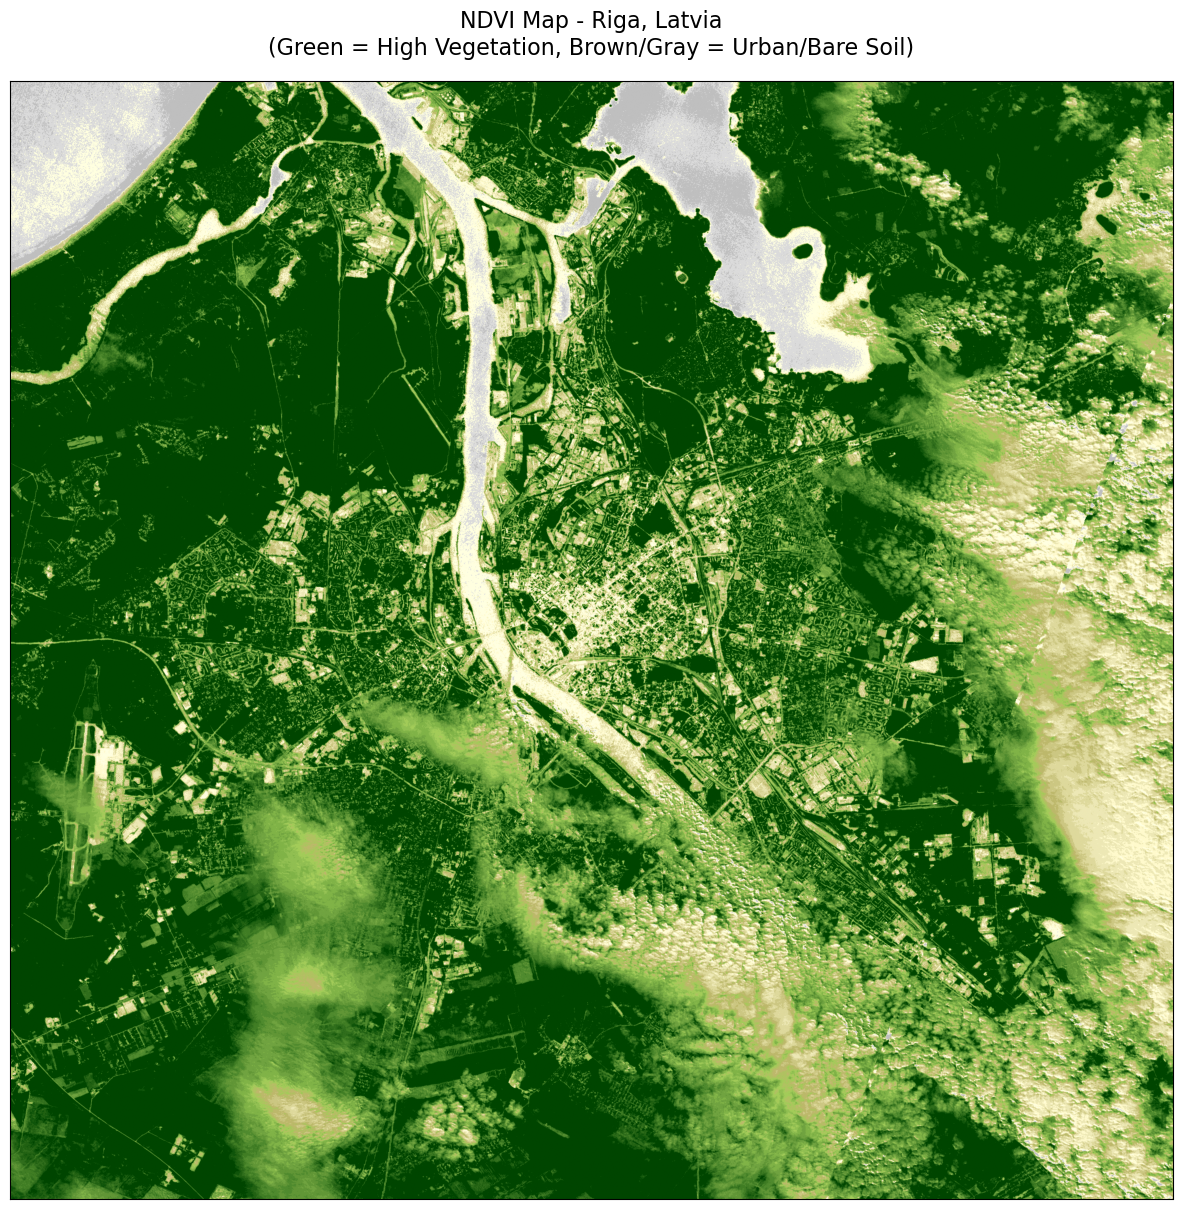

In [31]:
# Display the NDVI map
image = ndvi_img[0]
print("NDVI Map of Riga, Latvia")

# Plot NDVI map
plot_image(image, factor=1 / 255)
plt.title("NDVI Map - Riga, Latvia\n(Green = High Vegetation, Brown/Gray = Urban/Bare Soil)", fontsize=16, pad=20)
plt.show()

## Statistical API
In the Process API examples, we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Requesting, and plotting an NDVI time series for a single field

In the example here, we will calculate NDVI for a specific field of interest and then plot the mean NDVI and standard deviation over the requested time period. First we define our evalscript:

#### Define Field Boundaries

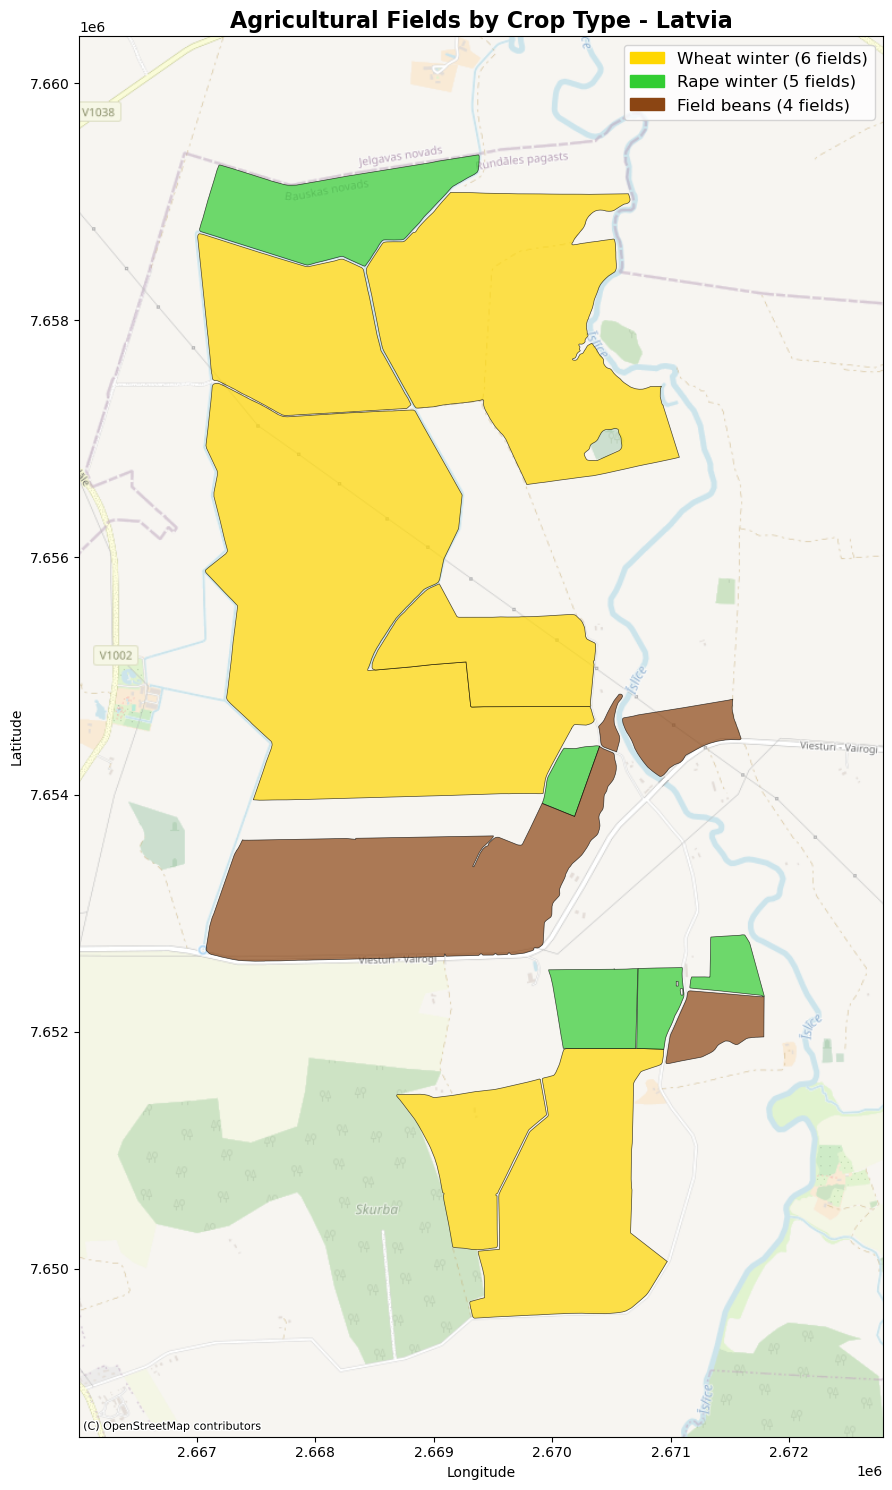

In [138]:
# Load the Latvia agricultural field boundaries with crop types
fields_gdf = gpd.read_file("latvia_fields_wgs84.geojson")

# Convert fields to Web Mercator for proper basemap alignment
fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Create a figure to visualize the three crop types
fig, ax = plt.subplots(figsize=(15, 15))

# Define colors for each crop type
crop_colors = {
    'Wheat winter': '#FFD700',      # Gold
    'Rape winter': '#32CD32',       # Lime green  
    'Field beans': '#8B4513'        # Saddle brown
}

# Plot each crop type with different colors
legend_handles = []
for crop_type, color in crop_colors.items():
    crop_fields = fields_gdf_wm[fields_gdf_wm['crop:name_en'] == crop_type]
    if len(crop_fields) > 0:
        plot = crop_fields.plot(ax=ax, 
                        color=color, 
                        alpha=0.7, 
                        edgecolor='black', 
                        linewidth=0.5)
        # Create a manual legend entry
        import matplotlib.patches as mpatches
        patch = mpatches.Patch(color=color, label=f'{crop_type} ({len(crop_fields)} fields)')
        legend_handles.append(patch)

# Set the axis limits to the bounds of the fields (with valid bounds now)
bounds = fields_gdf_wm.total_bounds
if np.isfinite(bounds).all():
    buffer = 1000  # 1km buffer around fields
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Add basemap for context
try:
    cx.add_basemap(ax, 
                    crs=fields_gdf_wm.crs, 
                    source=cx.providers.OpenStreetMap.Mapnik,
                    alpha=0.6)
except Exception as e:
    print(f"Could not add basemap: {e}")

# Add legend manually
if legend_handles:
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12)

# Set title and labels
ax.set_title('Agricultural Fields by Crop Type - Latvia', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## Extract NDVI Time Series for Fields

Calculate NDVI statistics for each field over time using the Statistical API. This provides mean NDVI values, standard deviation, and other statistics for monitoring vegetation changes throughout the growing season.

The evalscript is configured to return both NDVI and NDWI (Normalized Difference Water Index) for comprehensive vegetation and water monitoring.

In [109]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)


def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## Visualize NDVI Time Series

Create time series plots showing NDVI changes over time for the selected fields. This helps identify:

- **Seasonal patterns**: Natural vegetation cycles throughout the growing season
- **Crop development**: Growth stages from planting to harvest
- **Stress events**: Drought, disease, or other factors affecting vegetation health
- **Management practices**: Effects of irrigation, fertilization, or harvesting

**Note**: The visualization code below will work once you have valid credentials and field boundary data.

In [102]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

In [130]:
yearly_time_interval = "2024-01-01", "2024-08-31"

aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=yearly_time_interval,
    aggregation_interval="P10D",
    resolution=(0.0001, 0.0001),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
    maxcc=0.2,
)

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=fields_gdf.crs),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.13/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [131]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 79 ms, sys: 28.3 ms, total: 107 ms
Wall time: 2.5 s


15

### Manipulation and Visualisation of our Output

In [132]:
ndvi_dfs = [
    stats_to_df(polygon_stats).assign(id=id)
    for polygon_stats, id in zip(ndvi_stats, fields_gdf["id"].values)
]

ndvi_df = pd.concat(ndvi_dfs)

ndvi_df

interval_from interval_to  ndvi_B0_min  ndvi_B0_max  ndvi_B0_mean  \
0     2024-01-01  2024-01-11    -0.044162     0.318167      0.052375   
1     2024-01-11  2024-01-21    -0.050464     0.311673      0.036106   
2     2024-02-10  2024-02-20     0.298934     0.643664      0.506468   
3     2024-03-01  2024-03-11     0.291190     0.603629      0.408860   
4     2024-04-10  2024-04-20     0.379592     0.786089      0.675602   
..           ...         ...          ...          ...           ...   
7     2024-05-20  2024-05-30     0.336308     0.921225      0.476071   
8     2024-06-19  2024-06-29     0.420633     0.917431      0.787509   
9     2024-06-29  2024-07-09     0.485665     0.819977      0.739835   
10    2024-08-08  2024-08-18     0.436770     0.904595      0.621233   
11    2024-08-18  2024-08-28     0.437607     0.902453      0.610920   

    ndvi_B0_stDev  ndvi_B0_sampleCount  ndvi_B0_noDataCount       id  
0        0.061076                 1482                  497  4568929  
1        0.055683                 1482                  497  4568929  
2        0.053178                 1482                  497  4568929  
3        0.043832                 1482                  497  4568929  
4        0.075629                 1482                  497  4568929  
..            ...                  ...                  ...      ...  
7        0.146009                  432                  188  5099775  
8        0.071211                  432                  188  5099775  
9        0.056420                  432                  188  5099775  
10       0.104172                  432                  188  5099775  
11       0.115803                  432                  188  5099775  

[180 rows x 9 columns]

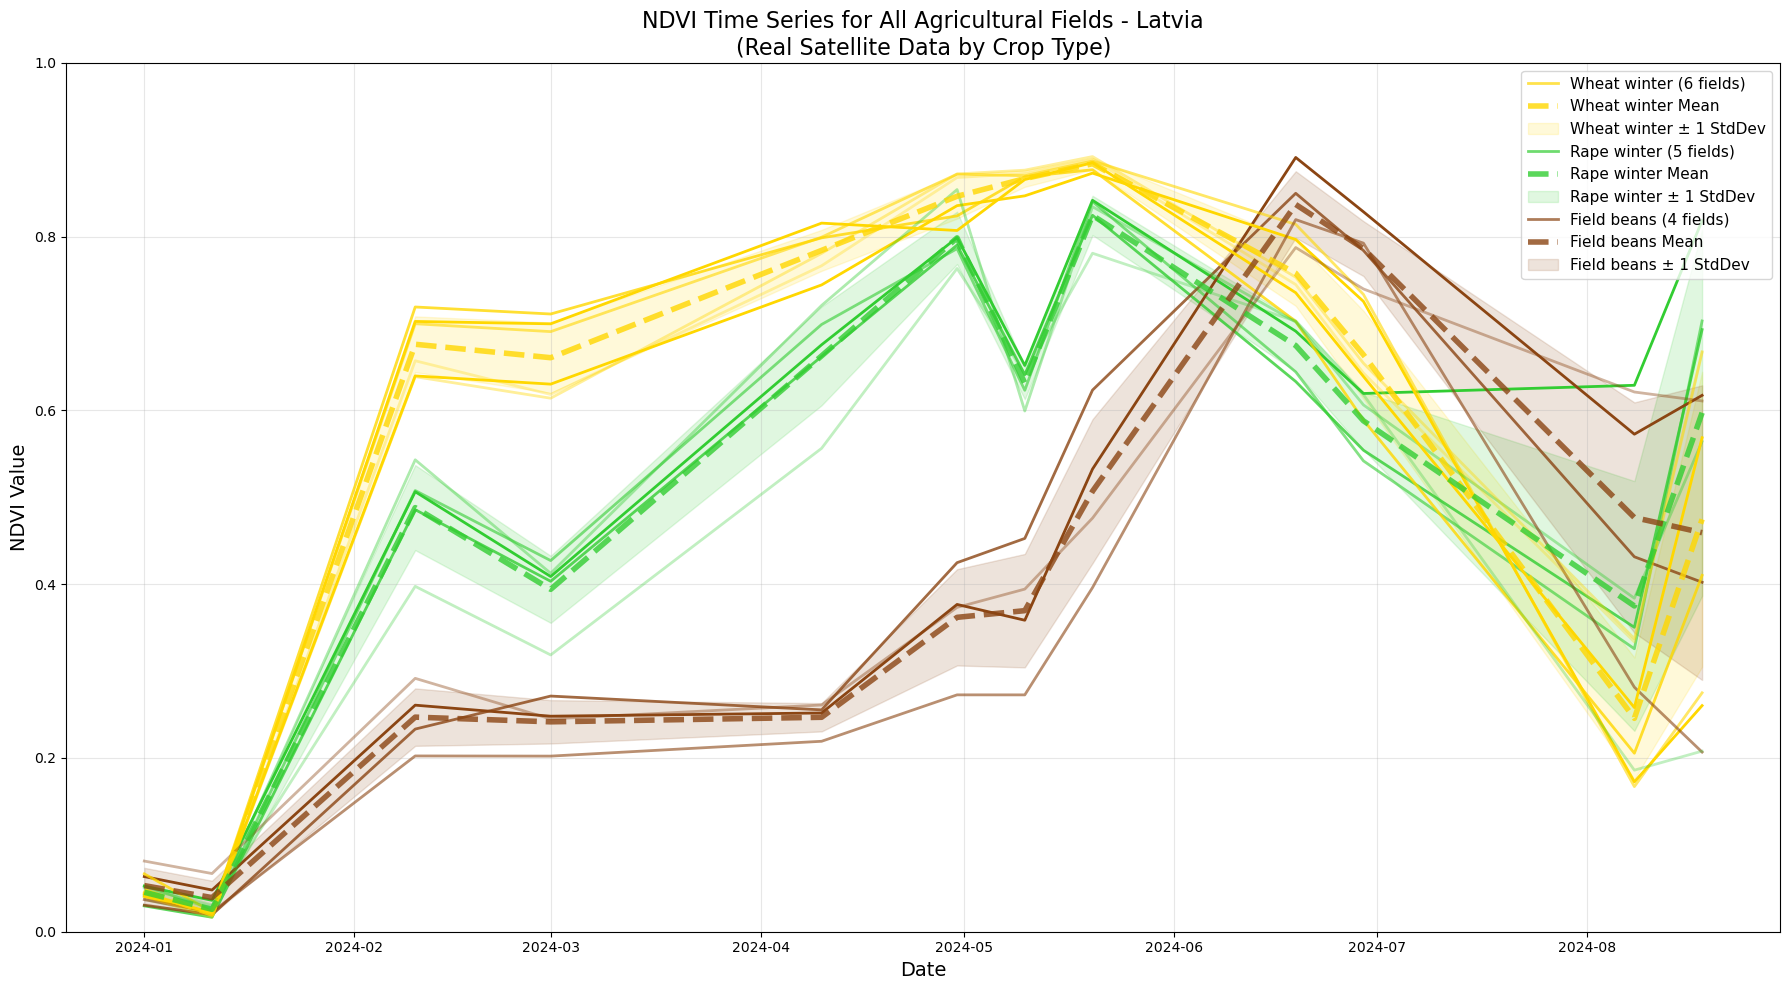

In [134]:
# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(18, 10))

# Define colors for each crop type (same as map)
crop_colors = {
    'Wheat winter': '#FFD700',      # Gold
    'Rape winter': '#32CD32',       # Lime green  
    'Field beans': '#8B4513'        # Saddle brown
}

# Create alpha variation for multiple fields of same crop type
alpha_values = [1.0, 0.8, 0.6, 0.4, 0.3]

# Counter for each crop type to vary alpha
crop_counters = {'Wheat winter': 0, 'Rape winter': 0, 'Field beans': 0}

# Store data for standard deviation calculation by crop type
crop_data = {'Wheat winter': [], 'Rape winter': [], 'Field beans': []}

# Extract the 'id' values from the GeoDataFrame
ids = fields_gdf["id"].values

# Plot individual field time series
for idx, field_id in enumerate(ids):
    # Get crop type for this field
    crop_type = fields_gdf[fields_gdf["id"] == field_id]['crop:name_en'].iloc[0]
    
    # Skip if crop type not in our color mapping
    if crop_type not in crop_colors:
        continue
    
    # Filter the DataFrame for the current field
    series = ndvi_df[ndvi_df["id"] == field_id].copy()
    
    if len(series) > 0:
        # Get color and alpha for this field
        color = crop_colors[crop_type]
        alpha = alpha_values[crop_counters[crop_type] % len(alpha_values)]
        crop_counters[crop_type] += 1
        
        # Plot the NDVI mean for the current series
        ax.plot(series["interval_from"], series["ndvi_B0_mean"], 
               color=color, alpha=alpha, linewidth=2,
               label=f'{crop_type} - {field_id}' if crop_counters[crop_type] <= 3 else None)
        
        # Store data for standard deviation calculation
        crop_data[crop_type].append(series)

# Calculate and plot standard deviation bands for each crop type
for crop_type, color in crop_colors.items():
    if len(crop_data[crop_type]) > 1:  # Need at least 2 fields to calculate std
        # Find common dates across all fields of this crop type
        all_dates = set()
        for series in crop_data[crop_type]:
            all_dates.update(series["interval_from"])
        common_dates = sorted(list(all_dates))
        
        # For each date, collect NDVI values from all fields of this crop type
        date_means = []
        date_stds = []
        
        for date in common_dates:
            values_for_date = []
            for series in crop_data[crop_type]:
                date_data = series[series["interval_from"] == date]
                if len(date_data) > 0:
                    values_for_date.append(date_data["ndvi_B0_mean"].iloc[0])
            
            if len(values_for_date) > 1:
                date_means.append(np.mean(values_for_date))
                date_stds.append(np.std(values_for_date))
            elif len(values_for_date) == 1:
                date_means.append(values_for_date[0])
                date_stds.append(0)
            else:
                date_means.append(np.nan)
                date_stds.append(np.nan)
        
        # Convert to arrays and filter out NaN values
        valid_indices = ~np.isnan(date_means)
        if np.any(valid_indices):
            valid_dates = [d for i, d in enumerate(common_dates) if valid_indices[i]]
            valid_means = [m for i, m in enumerate(date_means) if valid_indices[i]]
            valid_stds = [s for i, s in enumerate(date_stds) if valid_indices[i]]
            
            # Plot standard deviation band
            ax.fill_between(valid_dates, 
                           np.array(valid_means) - np.array(valid_stds), 
                           np.array(valid_means) + np.array(valid_stds),
                           alpha=0.15, color=color,
                           label=f'{crop_type} ± 1 StdDev')
            
            # Plot mean line
            ax.plot(valid_dates, valid_means, 
                   color=color, linewidth=4, alpha=0.8, linestyle='--',
                   label=f'{crop_type} Mean')

# Create legend with crop type groups, means, and std dev
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

legend_elements = []
for crop_type, color in crop_colors.items():
    count = crop_counters[crop_type]
    if count > 0:
        # Individual fields
        legend_elements.append(Line2D([0], [0], color=color, lw=2, alpha=0.7,
                                    label=f'{crop_type} ({count} fields)'))
        # Mean line and std dev (if more than 1 field)
        if count > 1:
            legend_elements.append(Line2D([0], [0], color=color, lw=4, alpha=0.8, linestyle='--',
                                        label=f'{crop_type} Mean'))
            legend_elements.append(mpatches.Patch(color=color, alpha=0.15, 
                                                label=f'{crop_type} ± 1 StdDev'))

ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# Formatting
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('NDVI Value', fontsize=14)
ax.set_title('NDVI Time Series for All Agricultural Fields - Latvia\n(Real Satellite Data by Crop Type)', fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Summary and Next Steps

This notebook provides a framework for satellite data analysis of Riga, Latvia using Sentinel Hub APIs. You have successfully:

✅ **Configured the environment** for accessing Copernicus Data Space Ecosystem  
✅ **Defined the area of interest** for Riga, Latvia  
✅ **Created evalscripts** for true color and NDVI visualization  
✅ **Set up time series analysis** framework for agricultural monitoring  

### To complete the analysis, you need to:

1. **Configure credentials**: Set up your Sentinel Hub client ID and secret
2. **Add field boundaries**: Replace the sample fields with actual agricultural field data for the Riga area
3. **Execute data requests**: Uncomment and run the data download sections
4. **Customize analysis**: Adjust time periods, cloud coverage thresholds, and resolution as needed

### Potential applications:
- **Crop monitoring**: Track vegetation health throughout growing seasons
- **Urban planning**: Analyze green space distribution in Riga
- **Environmental monitoring**: Study vegetation changes over time
- **Agricultural management**: Optimize farming practices based on satellite insights

### Data sources for Latvia:
- Latvian Geospatial Information Agency (LGIA) for administrative boundaries
- EU Common Agricultural Policy (CAP) data for field boundaries
- OpenStreetMap for urban features and land use classification

The framework is ready for operational use once you provide the necessary credentials and field boundary data.